In [11]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import tifffile as tiff
import pickle

import networkx as nx
from sklearn.model_selection import train_test_split

import torch_geometric.utils
import torch

In [12]:
%load_ext autoreload
%autoreload 2

p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

data_dir = (Path().cwd().parents[0] / 'data').absolute()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'
process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'

In [14]:
def visualize_graph(G, pos, color, **kwargs):
    fig, ax = plt.subplots(figsize=(15,15))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.set_facecolor('k')
    plt.show()

In [15]:
import scanpy as sc
import anndata as ad 
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

import networkx as nx
import matplotlib 

# Save data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'

# adata_combined = ad.read_h5ad(save_path / 'all.h5ad')
adata_foll = ad.read_h5ad(save_path / 'foll.h5ad')
name_map =  { '1':'B-cell', '7':'FDC',  '0': 'Ki67+ B-cell', '4': 'Ki67+', '18': 'FDC', '8':'Other',  '11':'Macrophage',  '6':'Macrophage', '6':'Macrophage', '3':'Plasma Cell', '13':'Other','5': 'Ki67+ Macrophage',}

adata_foll.obs['name'] = (
    adata_foll.obs["merged"]
    .map(lambda x: name_map.get(x, x))
    .astype("category")
)

adata_foll.uns["name_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata_foll.obs['name']))]

# Extract node class and colors
var = 'name'
sc.tl.dendrogram(adata_foll, 'name')

cluster_label_order = adata_foll.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_foll.uns[f"{var}_colors"]
labels = adata_foll.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

df_cell_info = adata_foll.obs.copy()


c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\scanpy\tools\_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\scanpy\tools\_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


# Get Dataset

In [16]:
import graph
import torch

from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'NIH_pos'

# Crate dataset
dataset = graph.GraphDatasetPos(process_path / name, process_path / name / 'info.csv', 2, y_name='covid')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [17]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.nc}')

Dataset: GraphDatasetPos(442):
Number of graphs: 442
Number of features: 6
Number of classes: 2


In [18]:
print(f'Train set: {len(train_set)}, val set: {len(test_set)}, val set: {len(val_set)}')

Train set: 213, val set: 176, val set: 53


# Load model

Get the best model from all

In [19]:
### Load GNN 
from graph.model import NodeLevelGNN, GraphLevelGNN, GraphLevelGNN_Moprh, GraphLevelGNN_Pos
from pytorch_lightning.utilities.model_summary import ModelSummary

# Model path
condition = '082923_Covid_pos'
checkpoint_folder = (Path().cwd().parents[0]).absolute() / 'data' / "saved_models" / f"Graph_GNNs_{condition}" 
project_name = f'SF_{condition}'

# Model parameters
NUM_LAYERS = 2
HIDDEN_CHANNELS = 16
pool = 'attention2'
model ='GAT'
fold =2
pl.seed_everything(42)

# Load model
CHECKPOINT_PATH = checkpoint_folder / f'{model}_{NUM_LAYERS}_{HIDDEN_CHANNELS}_{fold}' / pool
checkpoint = CHECKPOINT_PATH / f"GraphLevel{model}" / f"GraphLevel{model}.ckpt" 
graph_model = GraphLevelGNN_Pos.load_from_checkpoint(checkpoint, map_location=torch.device('cpu'))
graph_model.eval()

# Print model
summary = ModelSummary(graph_model)
print(summary)

Global seed set to 42


   | Name        | Type             | Params
--------------------------------------------------
0  | model       | GAT              | 5.1 K 
1  | fnn_layer   | Linear           | 272   
2  | selu        | SELU             | 0     
3  | head        | Linear           | 34    
4  | loss_module | CrossEntropyLoss | 0     
5  | train_acc   | BinaryAccuracy   | 0     
6  | train_auroc | BinaryAUROC      | 0     
7  | train_f1    | BinaryF1Score    | 0     
8  | valid_acc   | BinaryAccuracy   | 0     
9  | valid_auroc | BinaryAUROC      | 0     
10 | valid_f1    | BinaryF1Score    | 0     
11 | pool        | Attention_module | 281   
--------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


# Graph explainer

In [20]:
from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer, CaptumExplainer, AttentionExplainer
from torch_geometric.utils import remove_self_loops, to_undirected
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, edge_index):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

In [21]:
# COVID Positive
data = dataset[6]
data = dataset[350]

# COVID negativeq
# data = dataset[287]
# data = dataset[290]
# data = dataset[140]
print(data.x.shape[0], data.y, data.name)
data = data.to(graph_model.device)

1475 tensor(1) Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T5_43.pt


## Example 1

In [12]:
data = dataset[140]
print(data.x.shape[0], data.y, data.name)
data = data.to(graph_model.device)

2742 tensor(0) Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T18_36.pt


In [13]:
explainer = Explainer(
    model=graph_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torch_geometric\explain\explainer.py:189: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [15]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
# if data.y ==0:
#     edge_color = -edge_color
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)


16266 8133 8133


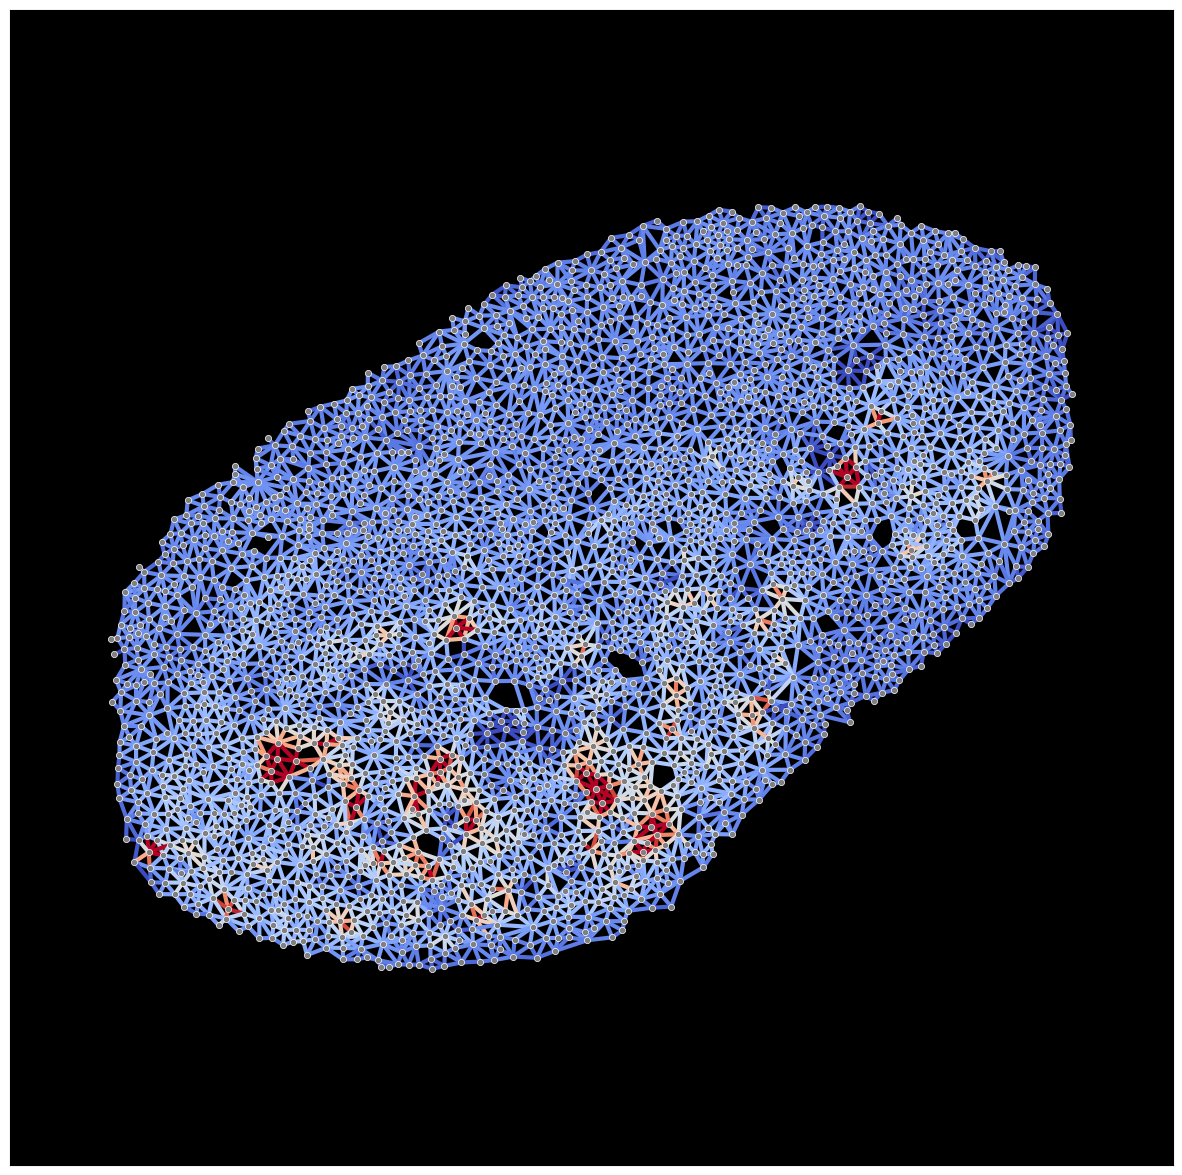

In [16]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

In [17]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

In [18]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)

16266 8133 8133


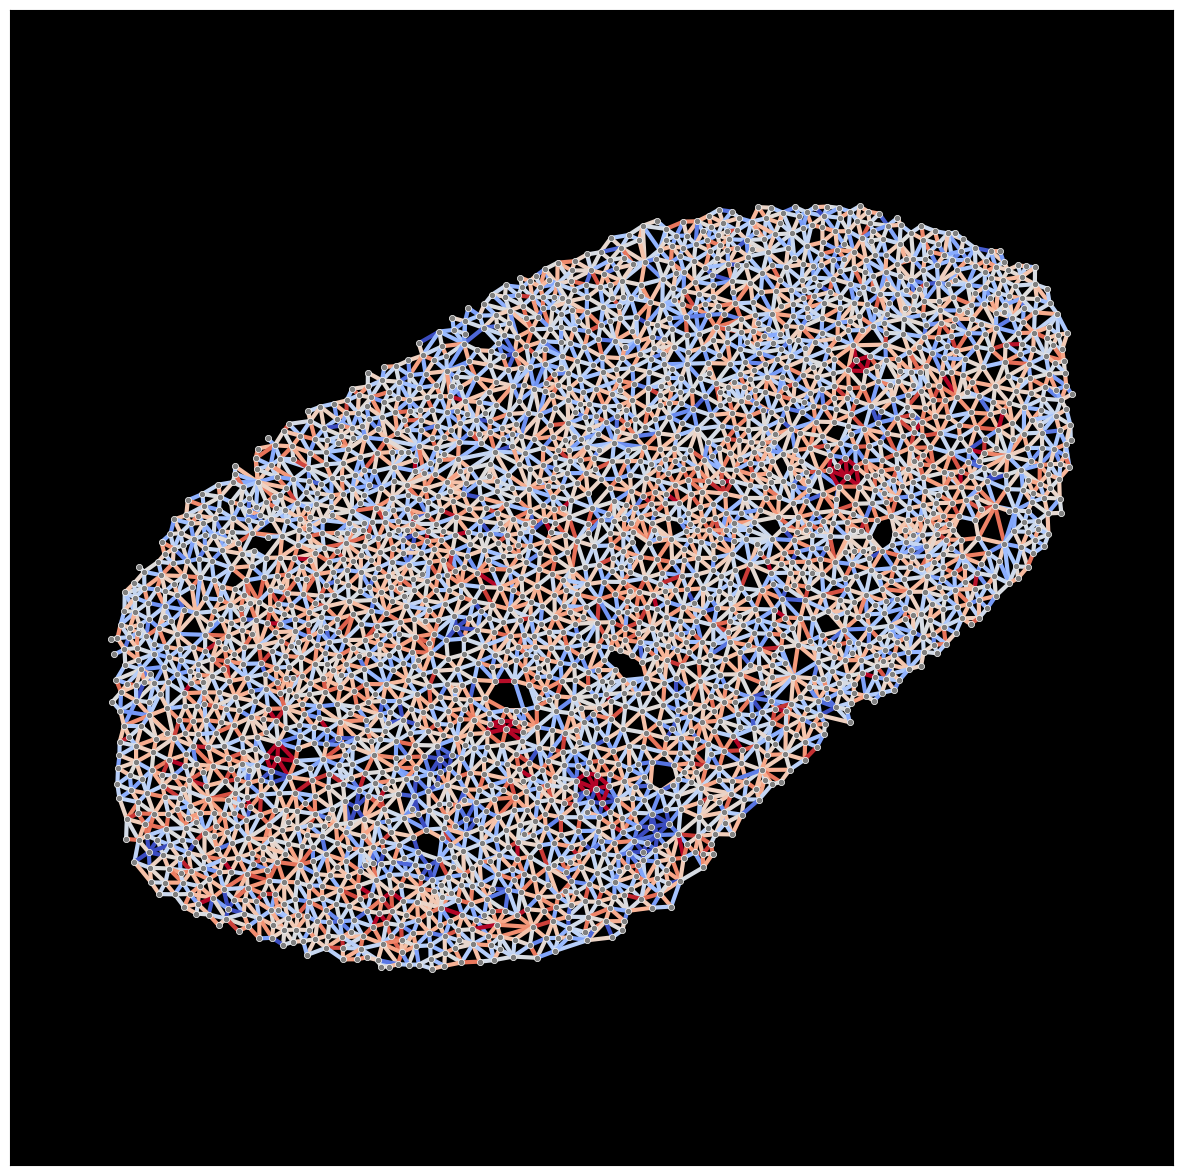

In [19]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

## Example 2

In [22]:
data = dataset[350]
print(data.x.shape[0], data.y, data.name)
data = data.to(graph_model.device)

1475 tensor(1) Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T5_43.pt


In [23]:
explainer = Explainer(
    model=graph_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torch_geometric\explain\explainer.py:189: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [24]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
# if data.y ==0:
#     edge_color = -edge_color
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)


8680 4340 4340


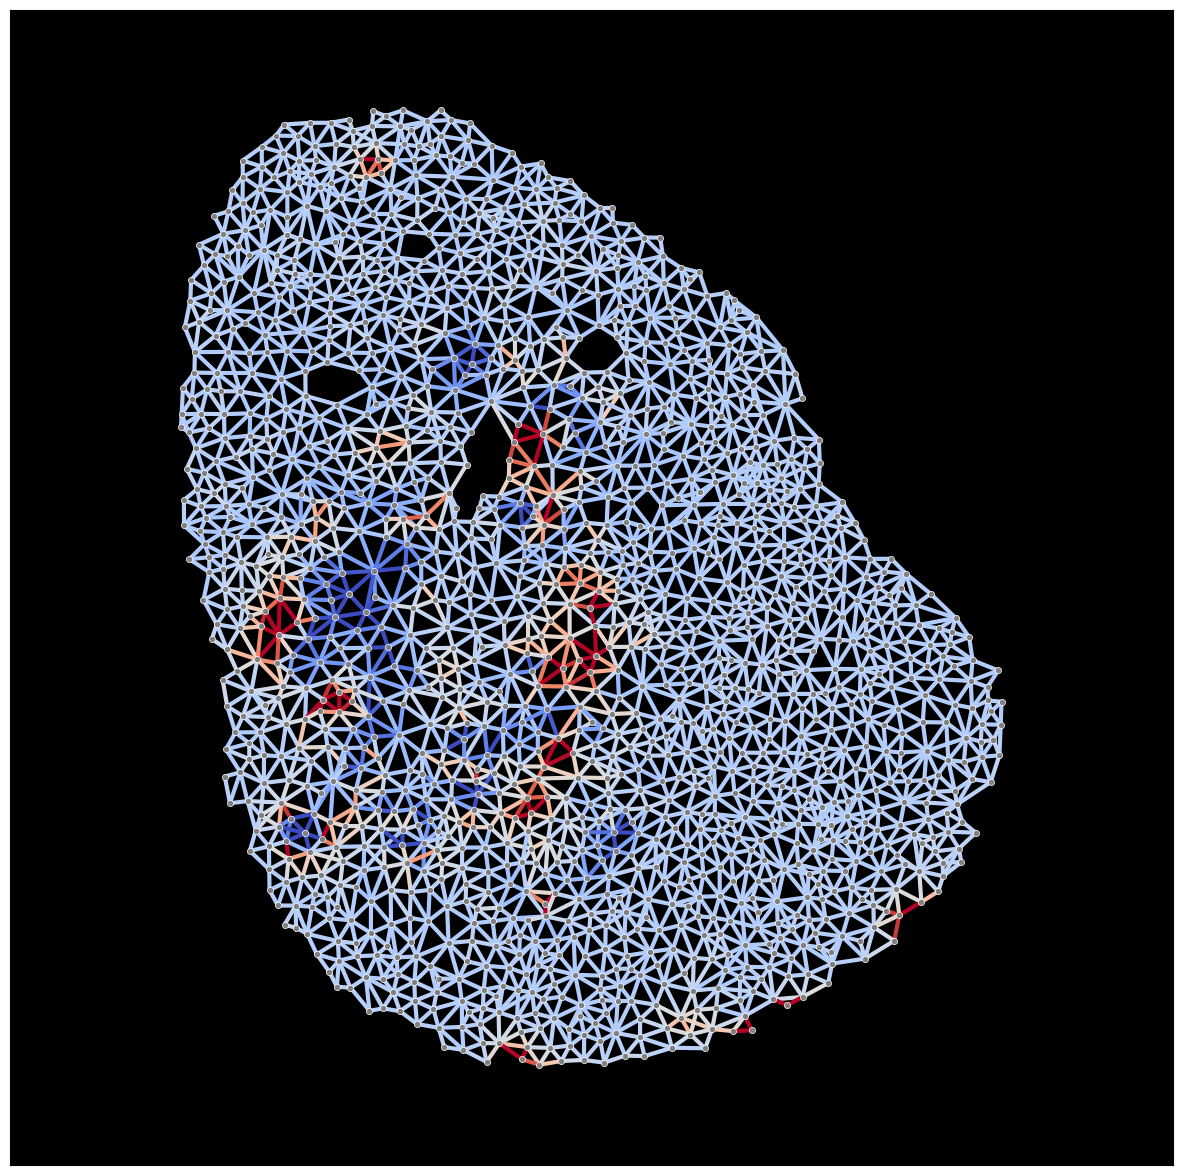

In [25]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

In [26]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

In [27]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)

8680 4340 4340


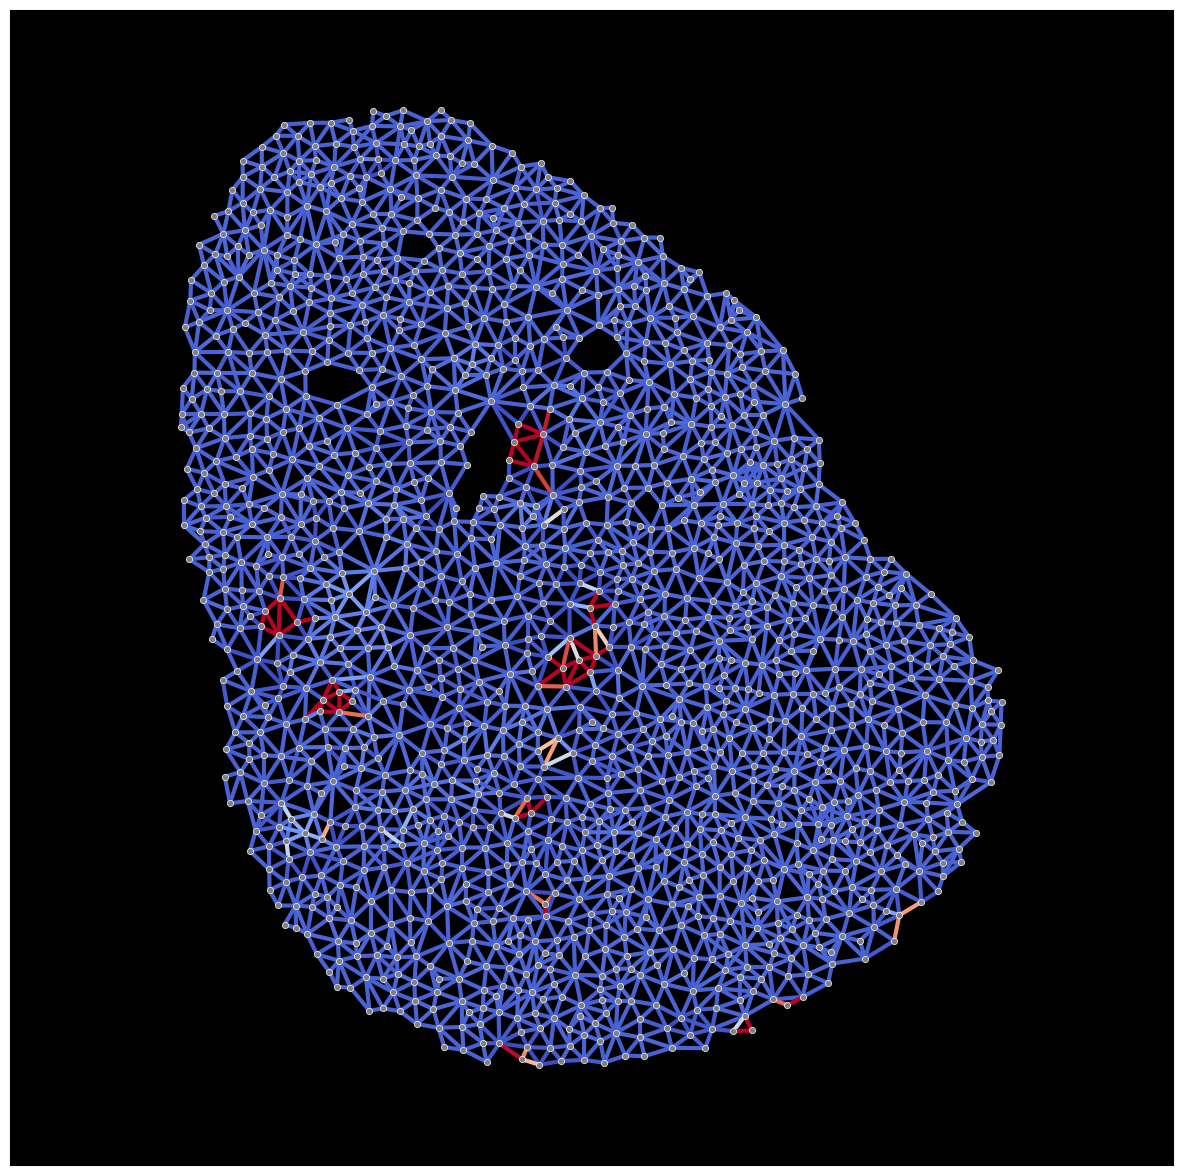

In [28]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)